# Using a DESC Equilibrium Output

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

## Loading in a DESC Equilibrium
DESC saves its output files as .h5 files, which can be loaded using the load function contained in the `desc.io` module

In [2]:
import desc.io

In DESC, equilibrium solutions are stored as `Equilibrium` objects, which contain the spectral coefficients of the solved equilibrium as well as the last-closed-flux-surface used to solve the equilibrium, the pressure and iota profiles, and other quantities that define the equilibrium. 

Often in DESC, a continuation method is employed to solve for equilibria where a sequence of related equilibria are computed until the final resolution and input parameters are reached. When calling DESC from the command line, this sequence of `Equilibrium` objects are stored inside an `EquilibriaFamily` object, which essentially acts as a list of `Equilibrium` objects with some extra functionality to aid in the continuation method.

We will load in the solution to the `HELIOTRON` example input file we solved in the previous notebook now.

In [3]:
eq_fam = desc.io.load("HELIOTRON_output.h5")
print(type(eq_fam))

DESC version 0.7.2+334.g1fe6b36e.dirty,using JAX backend, jax version=0.4.1, jaxlib version=0.4.1, dtype=float64
Using device: CPU, with 9.80 GB available memory
<class 'desc.equilibrium.equilibrium.EquilibriaFamily'>


As you can see, the object we just loaded in is an `EquilibriaFamily`. We can check to see how many equilibria this family contains (3, each corresponding to a different step in the continuation method outlined in the `HELIOTRON` input file). 

In [4]:
len(eq_fam)

8

We can visualize the different equilibria with the `plot_comparison` function, which plots flux surfaces and the contours of constant straight field-line poloidal angle $\vartheta=\theta+\lambda$ for multiple equilibria. 

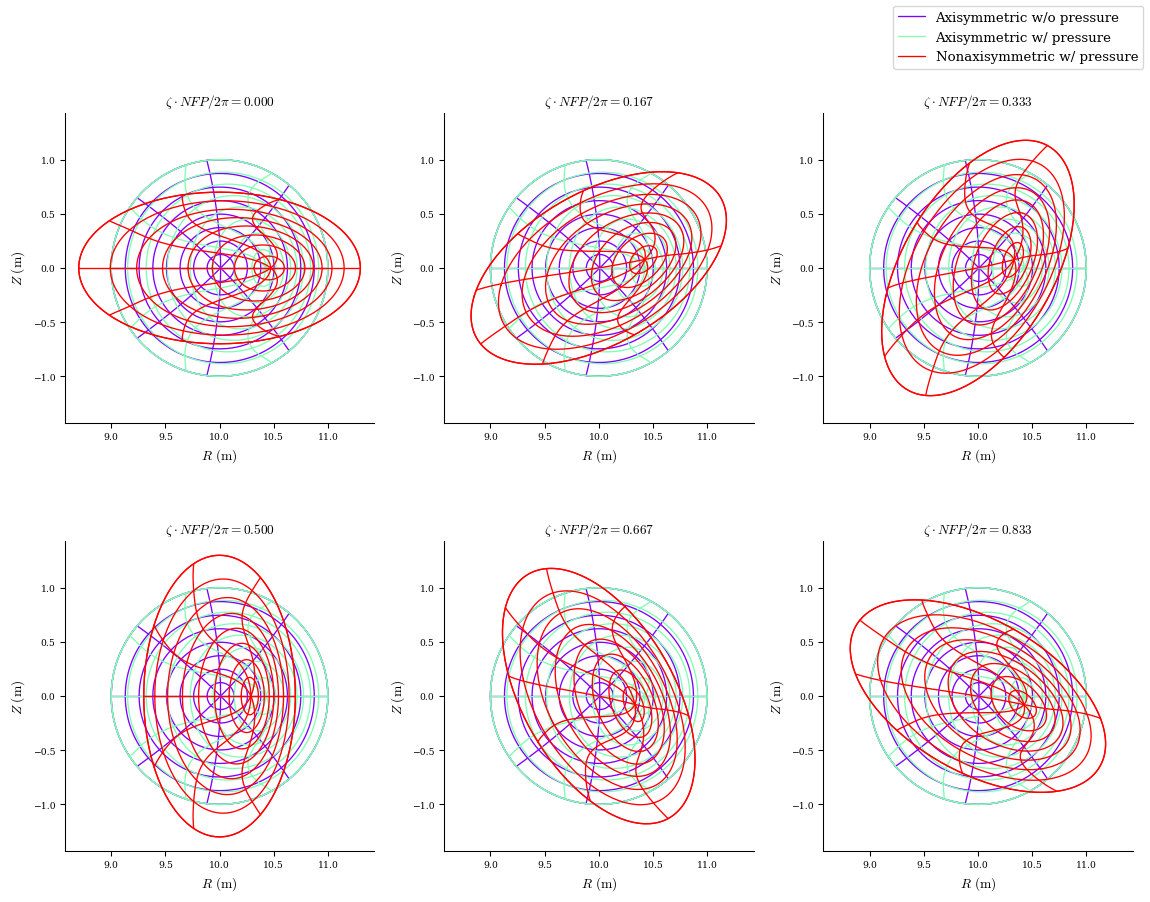

In [5]:
%matplotlib inline
from desc.plotting import plot_comparison

fig, ax = plot_comparison(
    eqs=[eq_fam[1], eq_fam[3], eq_fam[-1]],
    labels=[
        "Axisymmetric w/o pressure",
        "Axisymmetric w/ pressure",
        "Nonaxisymmetric w/ pressure",
    ],
)

## Computing Quantities from a DESC Equilibrium

Now let's focus on a single equilibrium. We can choose the final solution by indexing the last element of `eq_fam`

In [6]:
eq = eq_fam[-1]
print(type(eq))

<class 'desc.equilibrium.equilibrium.Equilibrium'>


Notice now we have an `Equilibrium` object, not an `EquilibriaFamily`. Printing an `Equilibrium` will list some information about it

In [7]:
print(eq)

Equilibrium at 0x7fb46d9e26a0 (L=12, M=12, N=3, NFP=19.0, sym=1, spectral_indexing=ansi)


Here we can see that this equilibrium solution has 19 field periods (`NFP=19`) and is represented with a Fourier-Zernike spectral basis with radial resolution of `L=8`, poloidal resolution of `M=8`, and toroidal resolution of `N=3`. It is stellarator symmetric (`sym=1`), and the spectral indexing scheme used for the Zernike Polynomial basis was the `ansi` indexing (for more information on the indexing schemes see the [DESC documentation](https://desc-docs.readthedocs.io/en/latest/notebooks/basis_grid.html#Zernike-Polynomials-and-Fourier-Zernike-basis)). 

Grids in DESC are objects from the `desc.grid` module. We typically want to plot at linearly spaced points, so we will use the `LinearGrid` class to make a 1-dimensional grid of points linearly spaced in $\rho$.

`grid.nodes` shows the points in the grid, each element being $(\rho,\theta,\zeta)$. Notice our grid is an array of points from $\rho=0$ to $\rho=1$ equally spaced, all at $\theta=\zeta=0$. 

In [8]:
from desc.grid import LinearGrid

grid_1d = LinearGrid(L=100)  # 101 linearly-spaced radial grid points
grid_1d.nodes[:10, :]  # show the first 10

array([[0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  ],
       [0.02, 0.  , 0.  ],
       [0.03, 0.  , 0.  ],
       [0.04, 0.  , 0.  ],
       [0.05, 0.  , 0.  ],
       [0.06, 0.  , 0.  ],
       [0.07, 0.  , 0.  ],
       [0.08, 0.  , 0.  ],
       [0.09, 0.  , 0.  ]])

We can visualize the grid using the `plot_grid` function.

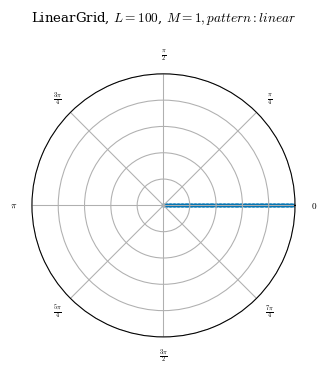

In [9]:
from desc.plotting import plot_grid

plot_grid(grid_1d);

`Equilibrium` objects have a `compute` method which can be used to compute many useful quantities (a full list of which can be found in the [DESC docs](https://desc-docs.readthedocs.io/en/latest/variables.html#list-of-variables)) that are commonly needed from an equilibrium. 

The `compute` method takes as arguments the name (as a string) of the desired quantity and the grid you wish the quantity to be computed on. It then returns a dictionary containing that quantity, as well as all the intermediate quantities needed to compute the desired quantity.

As an example, let's plot the pressure and rotational transform profiles of this equilibrium. 

In [10]:
pressure_data = eq.compute("p", grid=grid_1d)
iota_data = eq.compute("iota", grid=grid_1d)

In [11]:
pressure_data.keys()

dict_keys(['Te', 'ne', 'Ti', 'Zeff', 'p'])

In [12]:
iota_data.keys()

dict_keys(['rho', 'psi_r', 'iota'])

Notice that the returned dictionary for iota has more than just iota as a key. Generally, `eq.compute` will return the desired quantity along with each of its dependencies needed to calculate that quantity. Don't rely on this, to ensure that you get all the quantities you need, it is better to pass in explicitly each quantity, for example you want both `p` and `p_r`, you must call `eq.compute(["p","p_r"])`.

Let's plot the profiles now: 

Text(0, 0.5, 'iota')

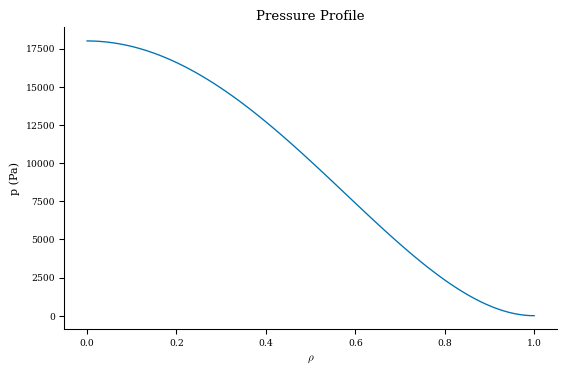

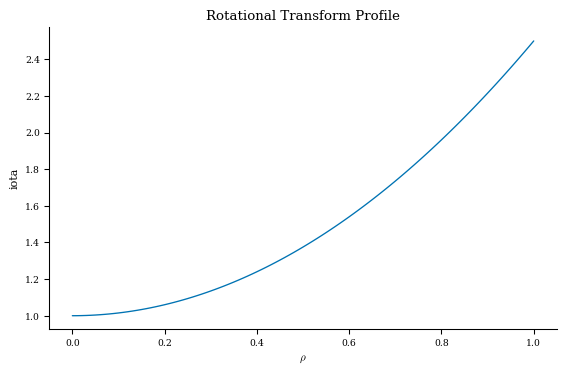

In [13]:
import matplotlib.pyplot as plt

p = pressure_data["p"]
iota = iota_data["iota"]

plt.figure()
plt.plot(grid_1d.nodes[:, 0], p)
plt.title("Pressure Profile")
plt.xlabel(r"$\rho$")
plt.ylabel("p (Pa)")

plt.figure()
plt.plot(grid_1d.nodes[:, 0], iota)
plt.title("Rotational Transform Profile")
plt.xlabel(r"$\rho$")
plt.ylabel("iota")

Now let's compute the magnetic field strength on the $\rho=0.5$ surface.

When making the grid we will specify that we want poloidal and toroidal grid points using $M$ and $N$, but only at the $\rho=0.5$ surface. Adding the `NFP` argument to the grid will ensure we have toroidal points only for a single field period.

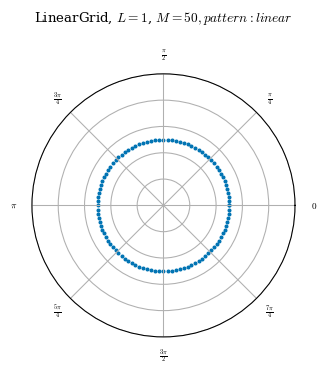

In [14]:
import numpy as np

# integer inputs specify the number of grid points in that dimension
# float or ndarray of floats specify the coordinate values
grid_2d_05 = LinearGrid(rho=np.array(0.5), M=50, N=50, NFP=eq.NFP, endpoint=True)
plot_grid(grid_2d_05);

Notice now that we have grid points at $\rho=0.5$ and $0\leq\theta<2\pi$ and $0\leq\zeta<\frac{2\pi}{NFP}$

In [15]:
mod_B_data = eq.compute("|B|", grid=grid_2d_05)

We can look at the returned dictionary now and see that all the intermediate quantities necessary to calculate `|B|` are also returned (the magnetic field covariant and contravariant components, metric tensor elements, etc.)

In [16]:
mod_B_data.keys()

dict_keys(['rho', 'psi_r', 'iota', '0', 'R_r', 'Z_r', 'e_rho', 'R_t', 'Z_t', 'e_theta', 'R', 'R_z', 'Z_z', 'e_zeta', 'sqrt(g)', 'B0', 'lambda_z', 'B^theta', 'lambda_t', 'B^zeta', 'B', '|B|^2', '|B|'])

In [17]:
mod_B = mod_B_data["|B|"]

To plot this 2d data, it is important to understand that in DESC all quantities and grid points are by default in a single stack. If we look at the shape of `grid_2d_05.nodes`, we can see that it is 10,000 nodes (1 $\rho$ coordinate x 100 $\theta$ coordinates x 100 $\zeta$ coordinates), each of length 3 $(\rho,\theta,\zeta)$. Similarly, `mod_B` is given at these 10,000 nodes.

In [18]:
grid_2d_05.nodes.shape

(10201, 3)

In [19]:
mod_B.shape

(10201,)

To plot this, we must reshape it into a 2D array as follows

Text(0.5, 1.0, '$|\\mathbf{B}|$ on $\\rho=0.5$ surface')

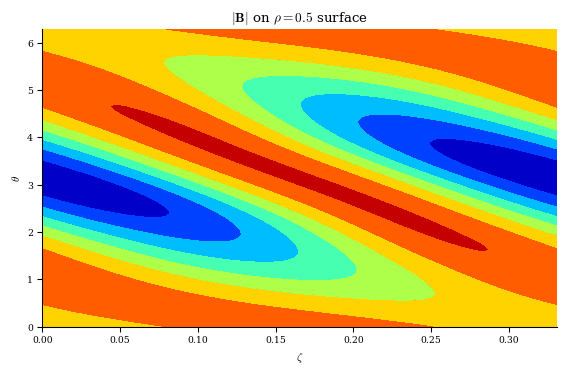

In [20]:
# reshape to form grids for plotting
zeta = (
    grid_2d_05.nodes[:, 2]
    .reshape((grid_2d_05.num_theta, grid_2d_05.num_rho, grid_2d_05.num_zeta), order="F")
    .squeeze()
)
theta = (
    grid_2d_05.nodes[:, 1]
    .reshape((grid_2d_05.num_theta, grid_2d_05.num_rho, grid_2d_05.num_zeta), order="F")
    .squeeze()
)
mod_B = mod_B.reshape(
    (grid_2d_05.num_theta, grid_2d_05.num_rho, grid_2d_05.num_zeta), order="F"
)

# plot contours of |B| on the rho=0.5 surface
plt.contourf(zeta, theta, mod_B[:, 0, :], cmap="jet")
plt.xlabel(r"$\zeta$")
plt.ylabel(r"$\theta$")
plt.title(r"$|\mathbf{B}|$ on $\rho=0.5$ surface")

Hopefully the process of computing quantities from a DESC equilibrium is clearer now. A full list of the quantities available for computation already in DESC is given in the [DESC documentation](https://desc-docs.readthedocs.io/en/latest/variables.html#list-of-variables)



## Plotting Utilities In DESC
For normal plotting needs, DESC has an extensive array of plotting utilities that can be used to quickly plot quantities of interest.

In [21]:
from desc.plotting import plot_1d, plot_2d, plot_3d, plot_section, plot_boozer_surface

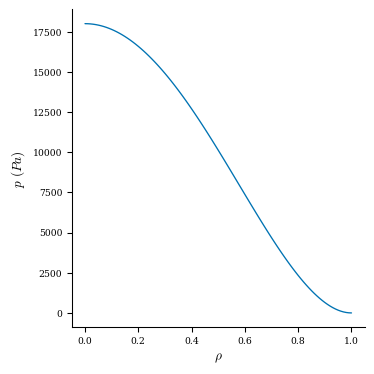

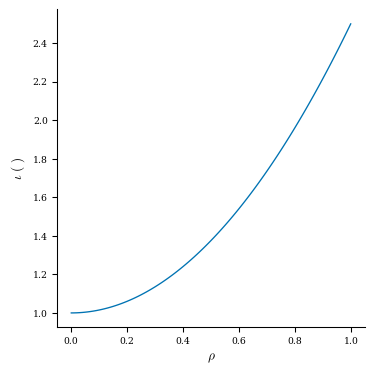

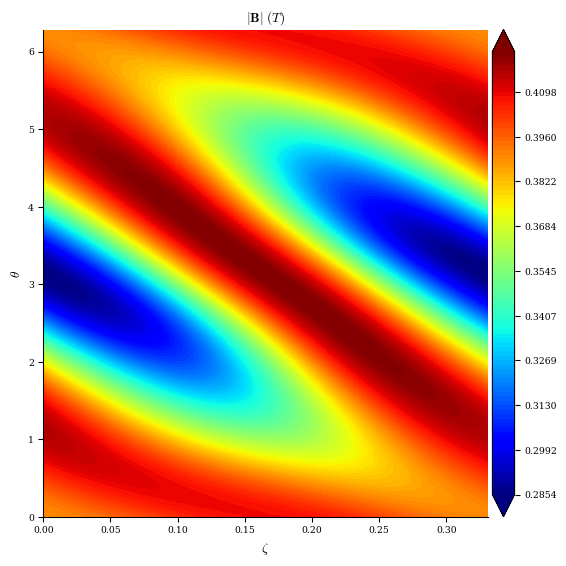

In [22]:
fig, ax = plot_1d(eq, "p")  # default grid is linearly spaced in rho
fig, ax = plot_1d(eq, "iota")
fig, ax = plot_2d(eq, "|B|", grid=grid_2d_05)  # plot |B| on rho=0.5 surface

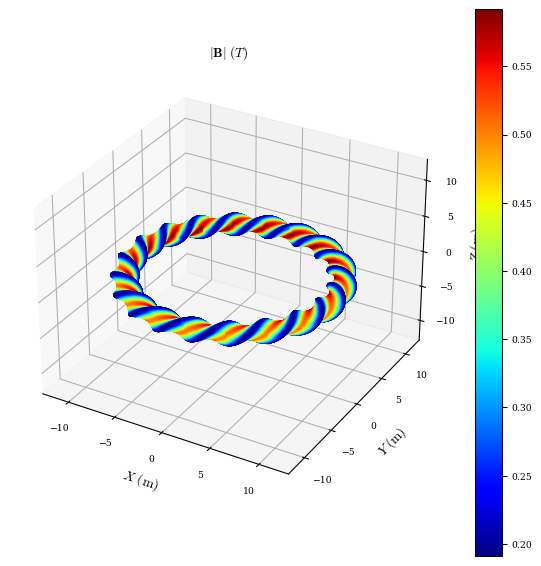

In [23]:
fig, ax = plot_3d(eq, "|B|")
# note that this example has 19 toroidal field periods

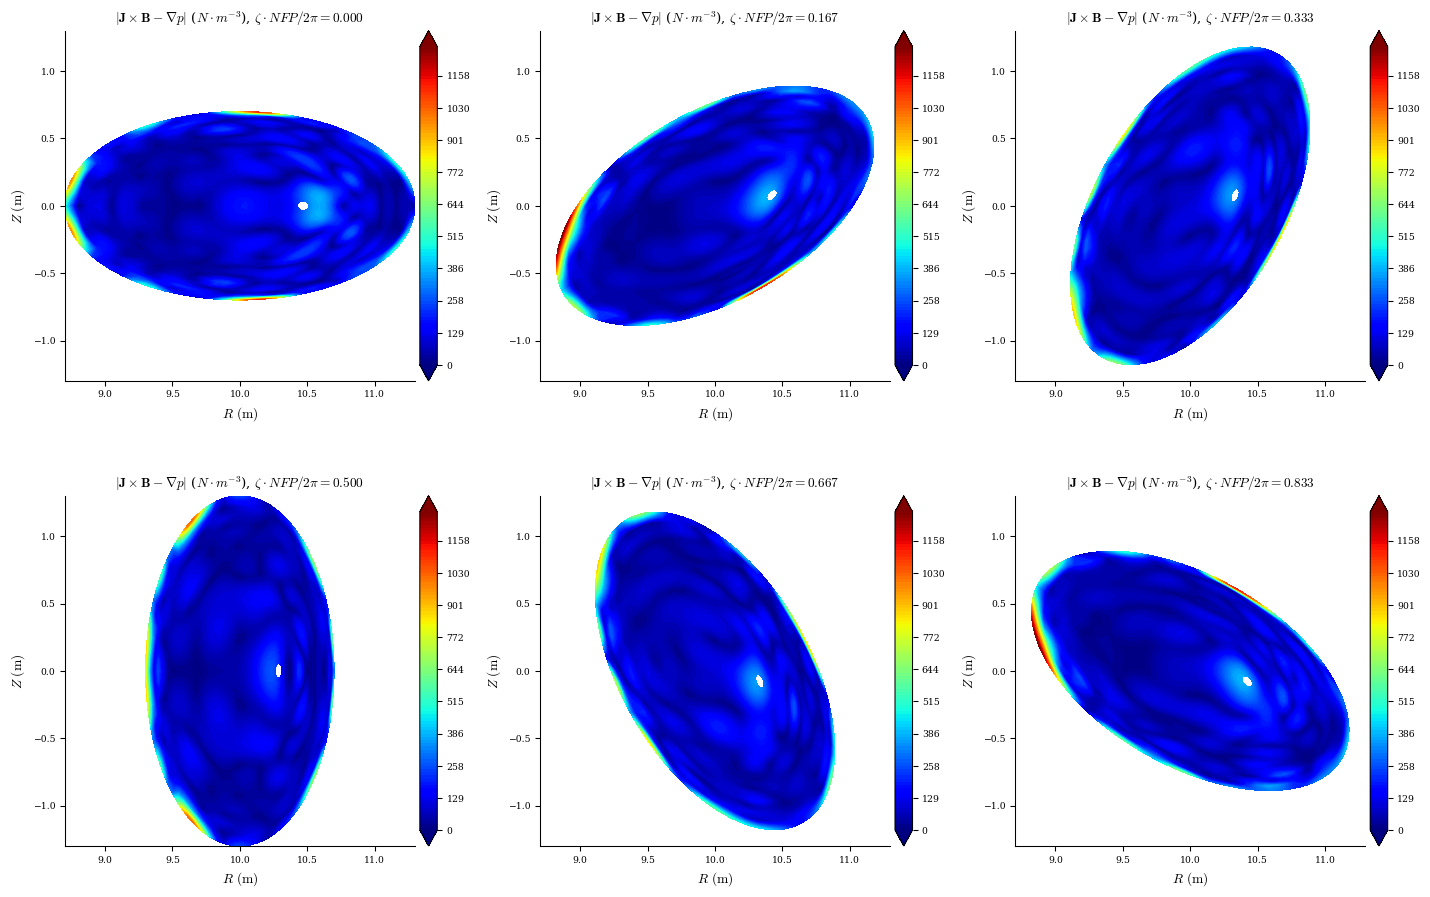

In [24]:
fig, ax = plot_section(eq, "|F|")  # plot force error

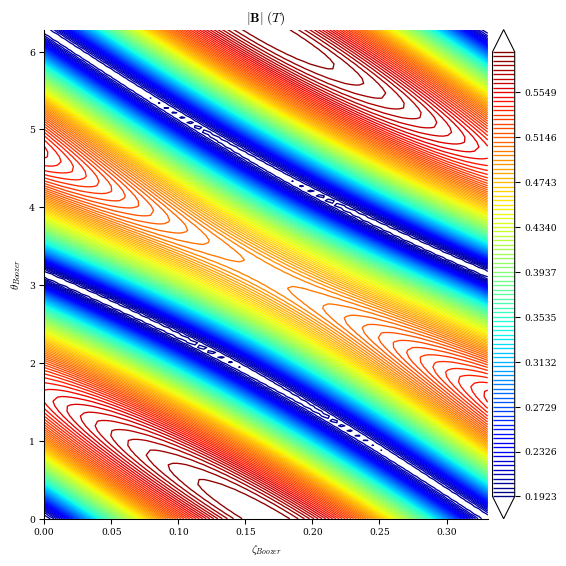

In [25]:
# |B| in Boozer coordinates on the rho=0.7 surface
fig, ax = plot_boozer_surface(
    eq, grid_plot=LinearGrid(rho=np.array(0.7), M=50, N=50, NFP=eq.NFP, endpoint=True)
)

Each of the plotting routines takes additional arguments that can be used to customize the appearance of the plots, full details can be found in the [documentation](https://desc-docs.readthedocs.io/en/stable/api.html#plotting).

Also note that each plotting function returns a handle to the Matplotlib figure and a numpy array of the axes used. These can then be further modified to customize the appearance of the plots.